In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

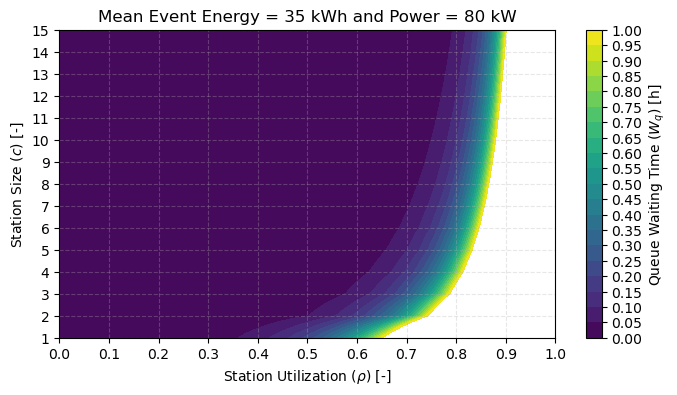

In [3]:
deep_reload(nice)

fig, ax = plt.subplots(1, 1, figsize = (8, 4))

cmap = nice.plot.Colormap('viridis')

m = 1 / (35 * 3.6e6 / 80e3)
queue = nice.queue.Queue(m = m)
levels = np.linspace(0, 1, 21)
x = np.linspace(0, 1, 100)
c = np.arange(1, 16, 1)
cg, xg = np.meshgrid(c, x, indexing = 'ij')
z = queue.interpolate(xg, cg) / 3600

kw = {
    'cmap': cmap.cmap,
    'levels': levels,
}
    
cb = ax.contourf(x, c, z, **kw)
ax.set_title(r'Mean Event Energy = 35 kWh and Power = 80 kW')

kw = {
    'label': r'Queue Waiting Time ($W_q$) [h]',
    'ticks': levels,
}

plt.colorbar(cb, ax = ax, **kw)


kw = {
    'xlabel': r'Station Utilization ($\rho$) [-]',
    'ylabel': r'Station Size ($c$) [-]',
    'xticks': np.linspace(0, 1, 11),
    'yticks': c,
}

ax.set(**kw)

kw = {
    'ls': '--',
    'alpha': .3,
}

ax.grid(**kw)

In [4]:
deep_reload(nice)

rng = np.random.default_rng(26893751)

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
}

atlas = nice.graph.nmu_graph(200, 3, **kw)

conditions = [
    lambda e: e['distance'] <= 300e3,
    lambda e: e['distance'] >= 100e3,
]

graph_o = nice.graph.all_pairs_graph(atlas, conditions, simple = True)

print(graph_o.number_of_nodes(), graph_o.number_of_edges())

# fig, ax = plt.subplots()

# _ = nice.plot.plot_graph(graph_o, nodes = {}, edges = {}, ax = ax)

200 7238


In [11]:
'''
Preparing the graph
'''
deep_reload(nice)

graph = graph_o.copy()

n = 30

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)
stations = list(set(graph.nodes) - set(places))

nodes = []
edges = []

m = graph.number_of_nodes()

for place in places:

    m += 1
    node = graph._node[place]
    
    nodes.append((m, node))
    stations.append(m)

    for p in graph.predecessors(place):

        edges.append((p, m, graph._adj[p][place]))

    for s in graph.successors(place):

        edges.append((m, s, graph._adj[place][s]))

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

'''
Adding classes
'''

for place in places:

    graph._node[place]['_class'] = 'Place'

'''
Adding Delay
'''

energy = 35 * 3.6e6
power = 80e3

m = 1 / (energy / power)
rho = np.linspace(0, 1, 10)
c = np.arange(1, 11, 1)

queue = nice.queue.Queue(m = m, bounds = (0, 24 * 3600))

for station in stations:

    station_c = rng.choice(c)

    volumes = rho * m * station_c
    delays = queue.interpolate(rho, station_c)

    graph._node[station]['_class'] = 'Station'
    graph._node[station]['volumes'] = volumes
    graph._node[station]['delays'] = delays * volumes / 3600
    

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = 'Path'

'''
Adding demands
'''
for place in places:

    destinations = set(places) - set([place])

    demands = rng.uniform(0, 1, size = len(destinations))
    demands /= demands.sum()

    graph._node[place]['demand'] = {p: demands[i] for i, p in enumerate(destinations)}
    # break

'''
Adding time to links
'''
for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']
        edge['ac_time'] = edge['distance'] / 20 * 3600 + edge['time']

'''
Making direct path links
'''
for origin in places:

    path = nx.shortest_path(graph, source = origin, weight = 'ac_time')

    for destination in places:

        costs = nice.graph.path_cost(
            graph, path[destination], fields = ['distance', 'ac_time']
        )
        
        costs['time'] = costs['ac_time']
        costs['direct'] = True
        
        graph.add_edge(origin, destination, **costs, _class = 'Path')
        
print(graph.number_of_nodes(), graph.number_of_edges())

230 9986


In [12]:
deep_reload(nice)

lg = nice.optimization.level_graph(
    graph, places[0], objective = 'distance', destinations = places
)

lg.number_of_nodes(), lg.number_of_edges()

(230, 4104)

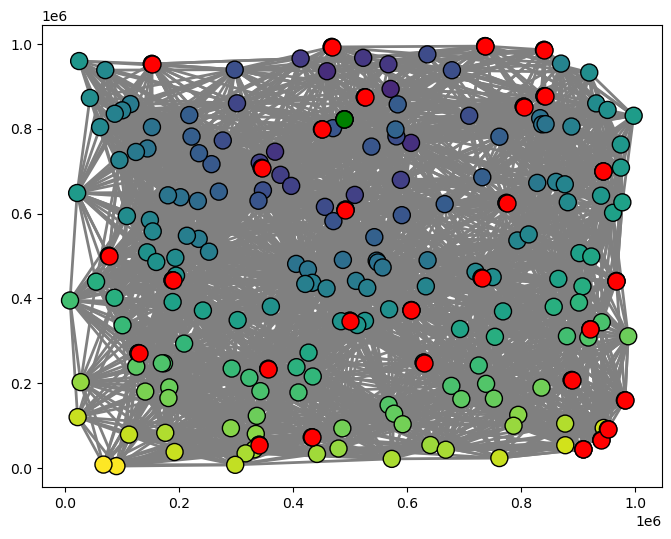

In [13]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'nodes': {
        'field': 'cost',
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
        },
    },
    'edges': {
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
sm = nice.plot.plot_graph(lg, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 150,
            'c': 'r',
            'zorder': 3,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(lg, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list([places[0]]),
        'plot': {
            's': 150,
            'c': 'g',
            'zorder': 3,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(lg, ax = ax, **kw)

In [14]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph)

network.build()

network.size()

Graph Transformed: 0.6401727199554443
Parameters Built: 0.0053784847259521484
Variables Built: 6.095114707946777
Constraints Built: 0.601149320602417
Objective Built: 0.3546171188354492


ModelSizeReport(activated = Bunch(binary_variables = 0, constraints = 7500, continuous_variables = 126278, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 126278), overall = Bunch(binary_variables = 0, constraints = 7500, continuous_variables = 300880, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 300880), warning = Bunch(unassociated_disjuncts = 0))

In [15]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

network.model.scale = 1
network.solve(**kw)
solution = network.solution

Problem Solved: 6.973985433578491
Results Collected: 0.37923192977905273


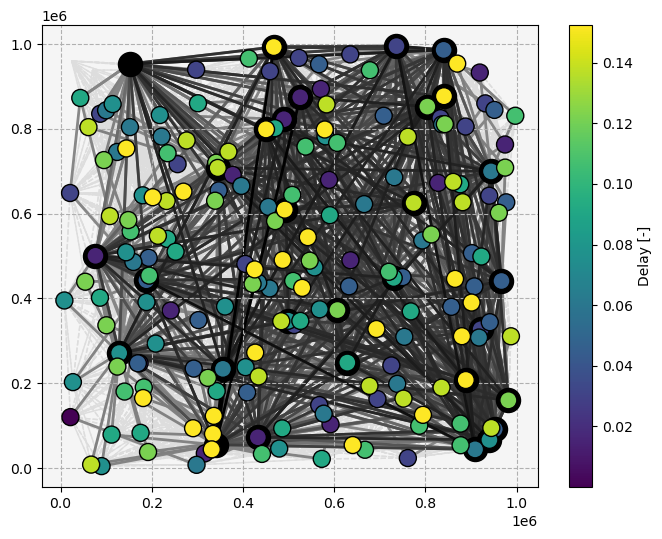

In [16]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

eps = 1e-8

selection = (
    [(s, t) for s, a in solution._adj.items() \
     for t, e in a.items() if e['total_flow'] > eps]
)

kw = {
    'nodes': {
        'field': 'delay',
        'cmap': nice.plot.Colormap(),
        'selection': [k for k, n in solution._node.items() if n.get('volume', 0) > 0],
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
            # 'vmin': .5,
        },
        'colorbar': {
            'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'total_flow',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
        # 'colorbar': {
        #     'label': 'Edge Flow',
        # },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 300,
            'fc': 'k',
            'ec': 'k',
            'zorder': 2,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [261]:
util = sum([n.get('utilization', 0) for k, n in solution._node.items()])
util

61.825

In [262]:
import pyomo.environ as pyomo

pyomo.value(network.model.objective)

2258546764.0752544

In [263]:
'''
Solving the model
'''
# deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

# scales = 

network.model.scale = 100

network.solve(**kw)
solution = network.solution

sum([n.get('utilization', 0) for k, n in solution._node.items()])

Problem Solved: 0.35517215728759766
Results Collected: 0.02287912368774414


61.825

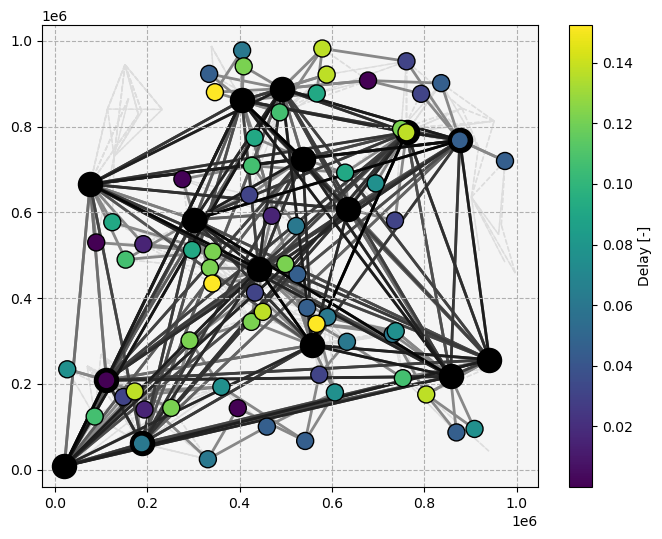

In [264]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

selection = (
    [(s, t) for s, a in solution._adj.items() for t, e in a.items() if e['total_flow'] > 0]
)

kw = {
    'nodes': {
        'field': 'delay',
        'cmap': nice.plot.Colormap('viridis'),
        'selection': [k for k, n in solution._node.items() if n.get('delay', 0) > 0],
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
        },
        'colorbar': {
            'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'total_flow',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 300,
            'fc': 'k',
            'ec': 'k',
            'zorder': 2,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [202]:
import pyomo.environ as pyomo

pyomo.value(network.model.objective) / 3600

22843.978915570777

In [265]:
'''
Preparing the graph
'''
deep_reload(nice)

graph = graph_o.copy()

n = 15

rng = np.random.default_rng(26589763514)

places = rng.choice(graph.nodes, replace = False, size = n)
stations = list(set(graph.nodes) - set(places))

nodes = []
edges = []

m = graph.number_of_nodes()

for place in places:

    m += 1
    node = graph._node[place]
    
    nodes.append((m, node))
    stations.append(m)

    for p in graph.predecessors(place):

        edges.append((p, m, graph._adj[p][place]))

    for s in graph.successors(place):

        edges.append((m, s, graph._adj[place][s]))

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

'''
Adding classes
'''

for place in places:

    graph._node[place]['_class'] = 'Place'

'''
Adding Delay
'''

energy = 35 * 3.6e6
power = 80e3

m = 1 / (energy / power)
rho = np.linspace(0, 1, 10)
c = np.arange(1, 11, 1)

queue = nice.queue.Queue(m = m, bounds = (0, 24 * 3600))

for station in stations:

    station_c = rng.choice(c)

    volumes = rho * m * station_c
    delays = queue.interpolate(rho, station_c)

    graph._node[station]['_class'] = 'Station'
    graph._node[station]['volumes'] = volumes * 3600
    graph._node[station]['delays'] = delays * volumes / 3600
    

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = 'Path'

'''
Adding demands
'''
for place in places:

    destinations = set(places) - set([place])

    demands = rng.uniform(0, 1, size = len(destinations))
    demands /= demands.sum()

    graph._node[place]['demand'] = {p: demands[i] for i, p in enumerate(destinations)}
    # break

'''
Adding time to links
'''
for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['speed'] = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / edge['speed']
        edge['ac_time'] = edge['distance'] / 20 * 3600 + edge['time']

'''
Making direct path links
'''
for origin in places:

    path = nx.shortest_path(graph, source = origin, weight = 'ac_time')

    for destination in places:

        costs = nice.graph.path_cost(
            graph, path[destination], fields = ['distance', 'ac_time']
        )
        
        costs['time'] = costs['ac_time']
        costs['direct'] = True
        # costs['capacity'] = .1
        
        graph.add_edge(origin, destination, **costs, _class = 'Path')
        
print(graph.number_of_nodes(), graph.number_of_edges())

115 1047


In [266]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': False,
}

network = nice.optimization.Network(**kw).from_graph(graph)

network.build()

network.size()

ModelSizeReport(activated = Bunch(binary_variables = 0, constraints = 1972, continuous_variables = 6638, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 6638), overall = Bunch(binary_variables = 0, constraints = 1972, continuous_variables = 16580, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 16580), warning = Bunch(unassociated_disjuncts = 0))

In [269]:
'''
Solving the model
'''
# deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

# scales = list(range(1, 500, ))
utilizations = []
delays = []
costs = []
dp_used = []
scales = np.arange(1, 200, 3)

prev = 0

for scale in nice.progress_bar.ProgressBar(scales):

    network.model.scale = scale
    
    network.solve(**kw)
    solution = network.solution
    
    utilizations.append(sum([n.get('utilization', 0) for k, n in solution._node.items()]))
    delays.append(sum([n.get('delay', 0) for k, n in solution._node.items()]))
    costs.append(pyomo.value(network.model.objective))

    dpu = 0

    for e in solution.edges():

        dpu += solution[e[0]][e[1]].get('direct', False) * solution[e[0]][e[1]]['total_flow'] > 0
    # scales.append(idx * 5)
    dp_used.append(dpu)

    rel_cost = pyomo.value(network.model.objective) / scale

    # print(prev / rel_cost)

    if prev / rel_cost >= .999:

        break

    else:

        prev = rel_cost

 [------------> ] (65/67) 97.01%, 2.56 it/s, 25.80 s elapsed, 0.39 s remaining

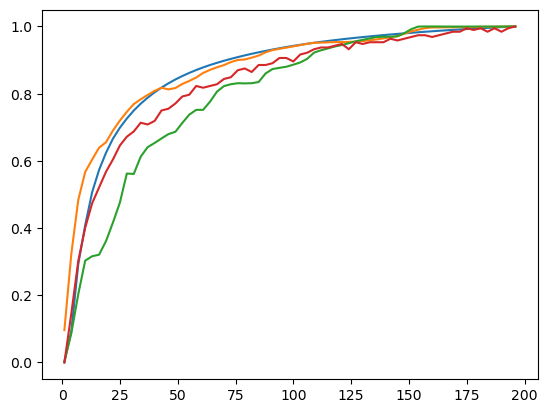

In [270]:
rc = np.array(costs) / scales[:len(costs)]

plt.plot(scales[:len(costs)], rc / max(rc))
plt.plot(scales[:len(costs)], np.array(utilizations) / max(utilizations))
plt.plot(scales[:len(costs)], np.array(delays) / max(delays))
plt.plot(scales[:len(costs)], np.array(dp_used) / max(dp_used))

In [271]:
'''
Solving the model
'''
# deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
    },
}

# scales = 

network.model.scale = 200

network.solve(**kw)
solution = network.solution

sum([n.get('utilization', 0) for k, n in solution._node.items()])

59.75154463911111

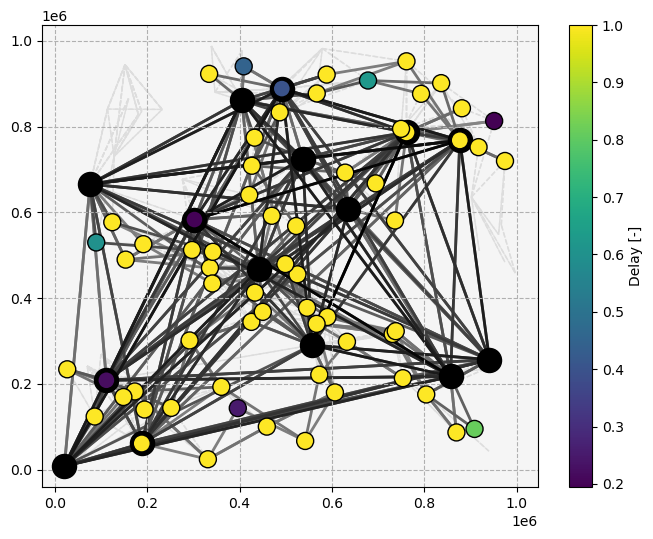

In [273]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

selection = (
    [(s, t) for s, a in solution._adj.items() for t, e in a.items() if e['total_flow'] > 0]
)

kw = {
    'nodes': {
        'field': 'utilization',
        'cmap': nice.plot.Colormap('viridis'),
        'selection': [k for k, n in solution._node.items() if n.get('delay', 0) > 0],
        'plot': {
            's': 150,
            'zorder': 3,
            'ec': 'k',
        },
        'colorbar': {
            'label': 'Delay [-]',
        },
    },
    'edges': {
        'field': 'total_flow',
        'selection': selection,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'plot': {
            's': 300,
            'fc': 'k',
            'ec': 'k',
            'zorder': 2,
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)